In [1]:
ASSET = "ETHUSDT"
TARGET = "Close"
SAVE_DF = f"./-for_optimization-/{ASSET}_{TARGET}_df.csv"
SAVE_SCALER = f"./-for_optimization-/{ASSET}_{TARGET}_scaler.pkl"
SAVE_MODEL = f"./-for_optimization-/{ASSET}_{TARGET}_model.keras"
SAVE_PREDICTIONS = f"./-for_optimization-/{ASSET}_{TARGET}_predictions.csv"


import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import importlib
# from __imports__ import *
import data, LSTM_returns
importlib.reload(data)


c:\Users\IC2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'data' from 'c:\\Users\\IC2594\\crypto\\folder-1\\data\\__init__.py'>

In [2]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

df = data.load_asset(ASSET, sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = add_technical_features(df)
df = df[df.index >= '2022-01-01']
df = df[df.index <= '2025-01-01']
split = len(df[df.index >= '2024-06-01']) / len(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-01,3765.54,154143.8968,Extreme Fear,0.024004,0.026033,42.401026,32.253914,-194.39,102.99,100.23,-2.76,0.499123,0.000711,-26.058066,3810.681429,3913.564286
2022-01-02,3828.27,154791.4263,Fear,0.016522,0.026513,44.955812,32.149459,-95.87,140.14,91.90,-48.24,0.524547,0.000770,-28.146396,3777.068571,3906.716429
2022-01-03,3765.89,236245.8586,Fear,-0.016429,0.026705,42.917239,32.213325,-178.84,173.09,24.98,-148.11,0.485007,0.000666,-30.916813,3738.305714,3893.942143
2022-01-04,3785.11,288258.5549,Extreme Fear,0.005091,0.026165,43.763398,31.865518,-229.04,187.62,134.84,-52.78,0.511717,0.000616,-30.063407,3737.214286,3877.582143
2022-01-05,3540.63,397942.0363,Extreme Fear,-0.066770,0.031075,36.376773,32.705154,-438.88,433.00,62.90,-370.10,0.461943,0.000657,-36.330352,3724.420000,3846.233571


In [3]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=split, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val), df_all, data_scaled



In [4]:
def objective(trial):
    global UNITS_L0, DROPOUT_L0, LEARNING_RATE, BATCH_SIZE, MAX_EPOCHS

    # Suggest hyperparameters
    UNITS_L0 = trial.suggest_int("units_l0", 50, 200)
    DROPOUT_L0 = trial.suggest_float("dropout_l0", 0.0, 0.5)
    LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    MAX_EPOCHS = trial.suggest_int("max_epochs", 10, 100)
    sequence_length = trial.suggest_int("sequence_length", 10, 60)


    # Train the LSTM model
    model, scaler, history, (X_val, y_val), _, _ = train_lstm(
        df,
        sequence_length=sequence_length,
        test_size=split,
        target=TARGET
    )

    # Predict on validation set
    y_pred = model.predict(X_val).flatten()

    # Create a placeholder array with zeros, except for the last column (target)
    dummy = np.zeros((len(y_pred), X_val.shape[2]))
    dummy[:, -1] = y_pred

    # Inverse transform using the entire dummy array
    y_pred_inv = scaler.inverse_transform(dummy)[:, -1]

    # Inverse transform for the actual values
    dummy_y_val = np.zeros((len(y_val), X_val.shape[2]))
    dummy_y_val[:, -1] = y_val
    y_val_inv = scaler.inverse_transform(dummy_y_val)[:, -1]

    # Calculate MSE
    mse = mean_squared_error(y_val_inv, y_pred_inv)

    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

[I 2025-05-09 19:33:42,404] A new study created in memory with name: no-name-66fbc7d0-8599-457b-b730-8fa56ad78fc7
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0778 - val_loss: 0.0083
Epoch 2/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0150 - val_loss: 0.0116
Epoch 3/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0106 - val_loss: 0.0243
Epoch 4/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - val_loss: 0.0291
Epoch 5/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073 - val_loss: 0.0161
Epoch 6/93
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0056 - val_loss: 0.0357
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-05-09 19:33:48,645] Trial 0 finished with value: 78676.91194780743 and parameters: {'units_l0': 88, 'dropout_l0': 0.3202242251433061, 'learning_rate': 0.003988801142988296, 'batch_size': 32, 'max_epochs': 93, 'sequence_length': 42}. Best is trial 0 with value: 78676.91194780743.


Epoch 1/60


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.2842 - val_loss: 0.0068
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0098 - val_loss: 0.0036
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0107 - val_loss: 0.0046
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0061 - val_loss: 0.0109
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0050 - val_loss: 0.0151
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - val_loss: 0.0165
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-05-09 19:33:55,173] Trial 1 finished with value: 34321.16668302391 and parameters: {'units_l0': 107, 'dropout_l0': 0.17118345770550258, 'learning_rate': 0.007993976526149091, 'batch_size': 32, 'max_epochs': 60, 'sequence_length': 19}. Best is trial 1 with value: 34321.16668302391.


Epoch 1/29


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0839 - val_loss: 0.0174
Epoch 2/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0232 - val_loss: 0.0194
Epoch 3/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0192 - val_loss: 0.0260
Epoch 4/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0184 - val_loss: 0.0316
Epoch 5/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0177 - val_loss: 0.0205
Epoch 6/29
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0195 - val_loss: 0.0310
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[I 2025-05-09 19:34:03,475] Trial 2 finished with value: 164351.0831452035 and parameters: {'units_l0': 192, 'dropout_l0': 0.4341206865131617, 'learning_rate': 0.0001451749559699742, 'batch_size': 16, 'max_epochs': 29, 'sequence_length': 23}. Best is trial 1 with value: 34321.16668302391.


Epoch 1/30


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0904 - val_loss: 0.0374
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0364 - val_loss: 0.0131
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0214 - val_loss: 0.0170
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0247 - val_loss: 0.0188
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0162 - val_loss: 0.0203
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0175 - val_loss: 0.0170
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0173 - val_loss: 0.0147
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


[I 2025-05-09 19:34:11,164] Trial 3 finished with value: 123552.83286353985 and parameters: {'units_l0': 165, 'dropout_l0': 0.41494616190221834, 'learning_rate': 0.0002533904064659641, 'batch_size': 64, 'max_epochs': 30, 'sequence_length': 13}. Best is trial 1 with value: 34321.16668302391.


Epoch 1/89


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0754 - val_loss: 0.0609
Epoch 2/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0599 - val_loss: 0.0522
Epoch 3/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0533 - val_loss: 0.0413
Epoch 4/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0553 - val_loss: 0.0355
Epoch 5/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0420 - val_loss: 0.0314
Epoch 6/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0390 - val_loss: 0.0267
Epoch 7/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0330 - val_loss: 0.0222
Epoch 8/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0277 - val_loss: 0.0187
Epoch 9/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0314 - val_loss: 0.0148
Epoch 10/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0294 - val_loss: 0.0140
Epoch 11/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0245 - val_loss: 0.0134
Epoch 12/89
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0239 - val_l

[I 2025-05-09 19:34:37,763] Trial 4 finished with value: 68503.72562778875 and parameters: {'units_l0': 81, 'dropout_l0': 0.4394662834566988, 'learning_rate': 1.288390700320287e-05, 'batch_size': 16, 'max_epochs': 89, 'sequence_length': 44}. Best is trial 1 with value: 34321.16668302391.


Epoch 1/31


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0484 - val_loss: 0.0250
Epoch 2/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0237 - val_loss: 0.0338
Epoch 3/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0230 - val_loss: 0.0455
Epoch 4/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0154 - val_loss: 0.0557
Epoch 5/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0118 - val_loss: 0.0555
Epoch 6/31
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0125 - val_loss: 0.0924
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


[I 2025-05-09 19:34:45,446] Trial 5 finished with value: 235384.0971855147 and parameters: {'units_l0': 81, 'dropout_l0': 0.48556232431340063, 'learning_rate': 0.003313671244712218, 'batch_size': 32, 'max_epochs': 31, 'sequence_length': 38}. Best is trial 1 with value: 34321.16668302391.


Epoch 1/32


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0830 - val_loss: 0.0072
Epoch 2/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 3/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 4/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 5/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 6/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 7/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 8/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 9/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0032 - val_loss: 0.0078
Epoch 10/32
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033 - val_loss: 0.0035
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


[I 2025-05-09 19:34:59,587] Trial 6 finished with value: 25196.820183884258 and parameters: {'units_l0': 153, 'dropout_l0': 0.06949469733165903, 'learning_rate': 0.002171316358138332, 'batch_size': 32, 'max_epochs': 32, 'sequence_length': 51}. Best is trial 6 with value: 25196.820183884258.


Epoch 1/65


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.1263 - val_loss: 0.0360
Epoch 2/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0221 - val_loss: 0.0083
Epoch 3/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0125 - val_loss: 0.0082
Epoch 4/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0074 - val_loss: 0.0057
Epoch 5/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 6/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 7/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 8/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 9/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 10/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 11/65
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0061 - val_loss: 0.0071
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[I 2025-05-09 19:35:07,590] Trial 7 finished with value: 41343.734941848685 and parameters: {'units_l0': 86, 'dropout_l0': 0.12249143055510925, 'learning_rate': 0.0007911981708014834, 'batch_size': 64, 'max_epochs': 65, 'sequence_length': 26}. Best is trial 6 with value: 25196.820183884258.


Epoch 1/66


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.1136 - val_loss: 0.0093
Epoch 2/66
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0237 - val_loss: 0.0221
Epoch 3/66
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0192 - val_loss: 0.0219
Epoch 4/66
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0153 - val_loss: 0.0085
Epoch 5/66
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0176 - val_loss: 0.0150
Epoch 6/66
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0149 - val_loss: 0.0105
Epoch 7/66
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0139 - val_loss: 0.0246
Epoch 8/66
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0123 - val_loss: 0.0252
Epoch 9/66
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0114 - val_loss: 0.0293
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-05-09 19:35:17,278] Trial 8 finished with value: 79780.75525227988 and parameters: {'units_l0': 80, 'dropout_l0': 0.36476804447891387, 'learning_rate': 0.001911158381712563, 'batch_size': 64, 'max_epochs': 66, 'sequence_length': 32}. Best is trial 6 with value: 25196.820183884258.


Epoch 1/77


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.1464 - val_loss: 0.1192
Epoch 2/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0439 - val_loss: 0.0311
Epoch 3/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0287 - val_loss: 0.0329
Epoch 4/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0157 - val_loss: 0.0171
Epoch 5/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0108 - val_loss: 0.0072
Epoch 6/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 8/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 9/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 10/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 11/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 12/77
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0059 - val_l

[I 2025-05-09 19:35:43,886] Trial 9 finished with value: 34090.250558257496 and parameters: {'units_l0': 150, 'dropout_l0': 0.06330846006617619, 'learning_rate': 9.03972000674871e-05, 'batch_size': 64, 'max_epochs': 77, 'sequence_length': 38}. Best is trial 6 with value: 25196.820183884258.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0307 - val_loss: 0.0053
Epoch 2/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 3/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 4/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 5/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 8.6592e-04 - val_loss: 0.0015
Epoch 9/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.9690e-04 - val_loss: 0.0025
Epoch 10/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 11/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.7727e-04 - val_loss: 0.0016
Epoch 12/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

[I 2025-05-09 19:36:03,229] Trial 10 finished with value: 13113.82143013811 and parameters: {'units_l0': 134, 'dropout_l0': 0.0023619414609485773, 'learning_rate': 0.0008776108182957995, 'batch_size': 32, 'max_epochs': 12, 'sequence_length': 60}. Best is trial 10 with value: 13113.82143013811.


Epoch 1/11


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0656 - val_loss: 0.0119
Epoch 2/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 3/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 4/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0017 - val_loss: 0.0054
Epoch 5/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 6/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 7/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 8/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 9/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 10/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 11/11
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016 - val_loss: 0.0021
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


[I 2025-05-09 19:36:24,227] Trial 11 finished with value: 17671.803623979038 and parameters: {'units_l0': 132, 'dropout_l0': 0.005910139068533663, 'learning_rate': 0.0007763834610382176, 'batch_size': 32, 'max_epochs': 11, 'sequence_length': 60}. Best is trial 10 with value: 13113.82143013811.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0588 - val_loss: 0.0102
Epoch 2/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 3/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 4/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 5/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 6/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 7/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 8/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 10/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 12/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.2

[I 2025-05-09 19:36:45,050] Trial 12 finished with value: 15000.37303275465 and parameters: {'units_l0': 125, 'dropout_l0': 0.00895423563240694, 'learning_rate': 0.0006344139544871484, 'batch_size': 32, 'max_epochs': 12, 'sequence_length': 59}. Best is trial 10 with value: 13113.82143013811.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0542 - val_loss: 0.0184
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0151 - val_loss: 0.0046
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0122 - val_loss: 0.0072
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0099 - val_loss: 0.0127
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0064 - val_loss: 0.0189
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0096 - val_loss: 0.0261
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0140 - val_loss: 0.0146
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[I 2025-05-09 19:37:00,586] Trial 13 finished with value: 43191.56943935166 and parameters: {'units_l0': 122, 'dropout_l0': 0.2253708614971781, 'learning_rate': 0.0006771500002884735, 'batch_size': 32, 'max_epochs': 10, 'sequence_length': 60}. Best is trial 10 with value: 13113.82143013811.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.4085 - val_loss: 0.4526
Epoch 2/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1141 - val_loss: 0.1181
Epoch 3/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0341 - val_loss: 0.0445
Epoch 4/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0221 - val_loss: 0.0386
Epoch 5/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0147 - val_loss: 0.0253
Epoch 6/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0102 - val_loss: 0.0209
Epoch 7/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0087 - val_loss: 0.0172
Epoch 8/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0073 - val_loss: 0.0150
Epoch 9/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0067 - val_loss: 0.0137
Epoch 10/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0070 - val_loss: 0.0130
Epoch 11/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0065 - val_loss: 0.0126
Epoch 12/46
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0

[I 2025-05-09 19:37:57,248] Trial 14 finished with value: 39876.36773793906 and parameters: {'units_l0': 117, 'dropout_l0': 0.009672392829753351, 'learning_rate': 5.068739495781952e-05, 'batch_size': 32, 'max_epochs': 46, 'sequence_length': 51}. Best is trial 10 with value: 13113.82143013811.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.1067 - val_loss: 0.0830
Epoch 2/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0222 - val_loss: 0.0195
Epoch 3/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0102 - val_loss: 0.0114
Epoch 4/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0098 - val_loss: 0.0157
Epoch 5/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 6/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0081 - val_loss: 0.0136
Epoch 7/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0085 - val_loss: 0.0126
Epoch 8/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0061 - val_loss: 0.0140
Epoch 9/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0061 - val_loss: 0.0112
Epoch 10/18
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0059 - val_loss: 0.0112
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


[I 2025-05-09 19:38:10,946] Trial 15 finished with value: 89040.58393574838 and parameters: {'units_l0': 57, 'dropout_l0': 0.13919401411394106, 'learning_rate': 0.0003746491225641856, 'batch_size': 32, 'max_epochs': 18, 'sequence_length': 52}. Best is trial 10 with value: 13113.82143013811.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/46
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0390 - val_loss: 0.0093
Epoch 2/46
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 3/46
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0100 - val_loss: 0.0145
Epoch 4/46
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0077 - val_loss: 0.0305
Epoch 5/46
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0069 - val_loss: 0.0235
Epoch 6/46
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0053 - val_loss: 0.0325
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-05-09 19:38:27,888] Trial 16 finished with value: 87806.37417251931 and parameters: {'units_l0': 176, 'dropout_l0': 0.26683416421286266, 'learning_rate': 0.001167082834367378, 'batch_size': 16, 'max_epochs': 46, 'sequence_length': 56}. Best is trial 10 with value: 13113.82143013811.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0137 - val_loss: 0.0028
Epoch 2/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 3/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0053 - val_loss: 0.0075
Epoch 4/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 5/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 6/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 7/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 8/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0035 - val_loss: 0.0072
Epoch 9/19
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0033 - val_loss: 0.0064
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


[I 2025-05-09 19:38:42,179] Trial 17 finished with value: 22602.3822354808 and parameters: {'units_l0': 139, 'dropout_l0': 0.06543329433368801, 'learning_rate': 0.0003252582376302736, 'batch_size': 32, 'max_epochs': 19, 'sequence_length': 47}. Best is trial 10 with value: 13113.82143013811.


Epoch 1/43


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.2199 - val_loss: 0.2846
Epoch 2/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0998 - val_loss: 0.1194
Epoch 3/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0443 - val_loss: 0.0540
Epoch 4/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0335 - val_loss: 0.0332
Epoch 5/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0268 - val_loss: 0.0213
Epoch 6/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0229 - val_loss: 0.0157
Epoch 7/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0180 - val_loss: 0.0122
Epoch 8/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0205 - val_loss: 0.0092
Epoch 9/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0185 - val_loss: 0.0084
Epoch 10/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0202 - val_loss: 0.0073
Epoch 11/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0150 - val_loss: 0.0073
Epoch 12/43
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0148 - val_l

[I 2025-05-09 19:39:13,027] Trial 18 finished with value: 56739.53976954204 and parameters: {'units_l0': 104, 'dropout_l0': 0.2158734968270828, 'learning_rate': 3.6656676747087185e-05, 'batch_size': 32, 'max_epochs': 43, 'sequence_length': 55}. Best is trial 10 with value: 13113.82143013811.


Epoch 1/20


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.2677 - val_loss: 0.0043
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049 - val_loss: 0.0061
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0041 - val_loss: 0.0057
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0044 - val_loss: 0.0139
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0051 - val_loss: 0.0098
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


[I 2025-05-09 19:39:27,209] Trial 19 finished with value: 27710.26596311351 and parameters: {'units_l0': 143, 'dropout_l0': 0.10189749225621898, 'learning_rate': 0.009459023498393514, 'batch_size': 16, 'max_epochs': 20, 'sequence_length': 32}. Best is trial 10 with value: 13113.82143013811.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.1083 - val_loss: 0.0326
Epoch 2/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 3/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0050 - val_loss: 0.0079
Epoch 4/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0038 - val_loss: 0.0072
Epoch 5/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 6/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0035 - val_loss: 0.0063
Epoch 7/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0027 - val_loss: 0.0066
Epoch 8/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0026 - val_loss: 0.0054
Epoch 9/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 10/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0024 - val_loss: 0.0052
Epoch 11/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 12/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0

[I 2025-05-09 19:40:19,042] Trial 20 finished with value: 16823.31135142214 and parameters: {'units_l0': 167, 'dropout_l0': 0.005727921238801679, 'learning_rate': 0.00016016980475787025, 'batch_size': 32, 'max_epochs': 39, 'sequence_length': 47}. Best is trial 10 with value: 13113.82143013811.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0338 - val_loss: 0.0054
Epoch 2/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0045 - val_loss: 0.0060
Epoch 3/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0031 - val_loss: 0.0051
Epoch 4/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0026 - val_loss: 0.0066
Epoch 5/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 6/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 7/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 8/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 9/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 10/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 11/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 12/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0

[I 2025-05-09 19:41:08,455] Trial 21 finished with value: 12552.310422180457 and parameters: {'units_l0': 169, 'dropout_l0': 0.006061276213351072, 'learning_rate': 0.000164179191092448, 'batch_size': 32, 'max_epochs': 39, 'sequence_length': 48}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0639 - val_loss: 0.0107
Epoch 2/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0050 - val_loss: 0.0075
Epoch 3/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 4/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 5/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 6/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 7/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 8/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 9/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0028 - val_loss: 0.0050
Epoch 10/23
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0037 - val_loss: 0.0035
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


[I 2025-05-09 19:41:34,190] Trial 22 finished with value: 25316.34310264583 and parameters: {'units_l0': 191, 'dropout_l0': 0.04621922653845954, 'learning_rate': 0.00045820674879516683, 'batch_size': 32, 'max_epochs': 23, 'sequence_length': 57}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0699 - val_loss: 0.0247
Epoch 2/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0119 - val_loss: 0.0102
Epoch 3/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0073 - val_loss: 0.0116
Epoch 4/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0079 - val_loss: 0.0117
Epoch 5/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0056 - val_loss: 0.0092
Epoch 6/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0076 - val_loss: 0.0121
Epoch 7/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 8/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0071 - val_loss: 0.0127
Epoch 9/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0061 - val_loss: 0.0103
Epoch 10/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0060 - val_loss: 0.0118
Epoch 11/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0056 - val_loss: 0.0100
Epoch 12/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0

[I 2025-05-09 19:42:01,248] Trial 23 finished with value: 51232.16961241743 and parameters: {'units_l0': 177, 'dropout_l0': 0.0977242199672375, 'learning_rate': 0.00019592628798597688, 'batch_size': 32, 'max_epochs': 53, 'sequence_length': 60}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/13


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0692 - val_loss: 0.0165
Epoch 2/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0107 - val_loss: 0.0082
Epoch 3/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0088 - val_loss: 0.0065
Epoch 4/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0067 - val_loss: 0.0099
Epoch 5/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0081 - val_loss: 0.0106
Epoch 6/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0053 - val_loss: 0.0110
Epoch 7/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0044 - val_loss: 0.0225
Epoch 8/13
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0038 - val_loss: 0.0146
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


[I 2025-05-09 19:42:16,310] Trial 24 finished with value: 61146.27416051307 and parameters: {'units_l0': 129, 'dropout_l0': 0.16202139485939093, 'learning_rate': 0.001387298927847062, 'batch_size': 32, 'max_epochs': 13, 'sequence_length': 54}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0880 - val_loss: 0.0663
Epoch 2/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0258 - val_loss: 0.0255
Epoch 3/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0126 - val_loss: 0.0133
Epoch 4/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 5/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0063 - val_loss: 0.0084
Epoch 6/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0056 - val_loss: 0.0092
Epoch 7/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 8/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0043 - val_loss: 0.0075
Epoch 9/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0036 - val_loss: 0.0076
Epoch 10/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0034 - val_loss: 0.0082
Epoch 11/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0036 - val_loss: 0.0087
Epoch 12/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

[I 2025-05-09 19:42:38,287] Trial 25 finished with value: 71133.23845655576 and parameters: {'units_l0': 160, 'dropout_l0': 0.03135443292490377, 'learning_rate': 6.120757992210525e-05, 'batch_size': 32, 'max_epochs': 37, 'sequence_length': 48}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.1889 - val_loss: 0.2864
Epoch 2/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0970 - val_loss: 0.1523
Epoch 3/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0518 - val_loss: 0.0771
Epoch 4/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0311 - val_loss: 0.0423
Epoch 5/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0197 - val_loss: 0.0276
Epoch 6/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0176 - val_loss: 0.0201
Epoch 7/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 8/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 9/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0116 - val_loss: 0.0131
Epoch 10/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 11/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0102 - val_loss: 0.0119
Epoch 12/24
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0

[I 2025-05-09 19:43:04,213] Trial 26 finished with value: 89875.96985749633 and parameters: {'units_l0': 110, 'dropout_l0': 0.09305769667533931, 'learning_rate': 2.1919788973006052e-05, 'batch_size': 32, 'max_epochs': 24, 'sequence_length': 42}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/54


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0986 - val_loss: 0.0241
Epoch 2/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0197 - val_loss: 0.0105
Epoch 3/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 4/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 5/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 6/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 7/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 8/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 9/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 10/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 11/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 12/54
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0036 - val_l

[I 2025-05-09 19:43:44,093] Trial 27 finished with value: 20229.87421141899 and parameters: {'units_l0': 139, 'dropout_l0': 0.03822118224343651, 'learning_rate': 9.630135245183711e-05, 'batch_size': 32, 'max_epochs': 54, 'sequence_length': 49}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.1145 - val_loss: 0.0197
Epoch 2/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0239 - val_loss: 0.0085
Epoch 3/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0152 - val_loss: 0.0120
Epoch 4/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0108 - val_loss: 0.0068
Epoch 5/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 6/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0119 - val_loss: 0.0070
Epoch 7/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 8/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0094 - val_loss: 0.0111
Epoch 9/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0087 - val_loss: 0.0112
Epoch 10/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0081 - val_loss: 0.0094
Epoch 11/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0095 - val_loss: 0.0109
Epoch 12/76
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0

[I 2025-05-09 19:44:01,099] Trial 28 finished with value: 56609.32855737396 and parameters: {'units_l0': 98, 'dropout_l0': 0.18047475100535582, 'learning_rate': 0.00046756717559117463, 'batch_size': 64, 'max_epochs': 76, 'sequence_length': 57}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.3119 - val_loss: 0.0053
Epoch 2/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0131 - val_loss: 0.0106
Epoch 3/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0104 - val_loss: 0.0064
Epoch 4/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 5/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0103 - val_loss: 0.0245
Epoch 6/16
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0084 - val_loss: 0.0309
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-05-09 19:44:14,821] Trial 29 finished with value: 49909.51979364581 and parameters: {'units_l0': 180, 'dropout_l0': 0.2819557056577124, 'learning_rate': 0.005804980990790626, 'batch_size': 16, 'max_epochs': 16, 'sequence_length': 41}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/26
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.1775 - val_loss: 0.0066
Epoch 2/26
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0192 - val_loss: 0.0182
Epoch 3/26
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0153 - val_loss: 0.0283
Epoch 4/26
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0170 - val_loss: 0.0110
Epoch 5/26
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0115 - val_loss: 0.0182
Epoch 6/26
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0080 - val_loss: 0.0259
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


[I 2025-05-09 19:44:27,250] Trial 30 finished with value: 62107.046042137394 and parameters: {'units_l0': 151, 'dropout_l0': 0.32691754838277776, 'learning_rate': 0.0033339182936888787, 'batch_size': 32, 'max_epochs': 26, 'sequence_length': 53}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/41


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.1063 - val_loss: 0.0352
Epoch 2/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0111 - val_loss: 0.0054
Epoch 3/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 4/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 5/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 6/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 7/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 8/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 9/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 10/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 11/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 12/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016 - val_l

[I 2025-05-09 19:44:56,842] Trial 31 finished with value: 20169.05080270394 and parameters: {'units_l0': 166, 'dropout_l0': 0.009976310206256623, 'learning_rate': 0.0001593599332411016, 'batch_size': 32, 'max_epochs': 41, 'sequence_length': 45}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0858 - val_loss: 0.0116
Epoch 2/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 3/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 4/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 5/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 6/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 7/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 9/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 10/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 11/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 12/37
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0

[I 2025-05-09 19:45:28,820] Trial 32 finished with value: 19527.697999432112 and parameters: {'units_l0': 198, 'dropout_l0': 0.03009559532291582, 'learning_rate': 0.0002152677415418797, 'batch_size': 32, 'max_epochs': 37, 'sequence_length': 46}. Best is trial 21 with value: 12552.310422180457.
C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


Epoch 1/38
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0499 - val_loss: 0.0352
Epoch 2/38
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 3/38
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0068 - val_loss: 0.0124
Epoch 4/38
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0052 - val_loss: 0.0133
Epoch 5/38
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 6/38
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0047 - val_loss: 0.0121
Epoch 7/38
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0055 - val_loss: 0.0141
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2025-05-09 19:45:40,652] Trial 33 finished with value: 113760.96405276888 and parameters: {'units_l0': 167, 'dropout_l0': 0.06357556637649492, 'learning_rate': 0.0001048182855888554, 'batch_size': 32, 'max_epochs': 38, 'sequence_length': 58}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/50


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0368 - val_loss: 0.0043
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0024 - val_loss: 0.0065
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0016 - val_loss: 0.0034
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2025-05-09 19:45:55,622] Trial 34 finished with value: 23332.34114316692 and parameters: {'units_l0': 185, 'dropout_l0': 0.0219360796578862, 'learning_rate': 0.0005960200180999202, 'batch_size': 32, 'max_epochs': 50, 'sequence_length': 49}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/59


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0298 - val_loss: 0.0039
Epoch 2/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 3/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 4/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 5/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 6/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 7/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 8/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 9/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.8762e-04 - val_loss: 0.0021
Epoch 10/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 11/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 12/59
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0

[I 2025-05-09 19:46:03,437] Trial 35 finished with value: 16383.63318155945 and parameters: {'units_l0': 115, 'dropout_l0': 0.004526916558150563, 'learning_rate': 0.0011587071644608119, 'batch_size': 32, 'max_epochs': 59, 'sequence_length': 12}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/60


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0273 - val_loss: 0.0033
Epoch 2/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0033
Epoch 3/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 4/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 5/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0059
Epoch 6/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 7/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0124
Epoch 8/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0068
Epoch 9/60
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 0.0099
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2025-05-09 19:46:08,805] Trial 36 finished with value: 23177.38794670486 and parameters: {'units_l0': 96, 'dropout_l0': 0.08469983036700195, 'learning_rate': 0.001280775819472236, 'batch_size': 16, 'max_epochs': 60, 'sequence_length': 12}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/93


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1124 - val_loss: 0.0075
Epoch 2/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - val_loss: 0.0065
Epoch 3/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - val_loss: 0.0060
Epoch 4/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - val_loss: 0.0086
Epoch 5/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - val_loss: 0.0042
Epoch 6/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - val_loss: 0.0036
Epoch 7/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 8/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 9/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - val_loss: 0.0090
Epoch 10/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - val_loss: 0.0190
Epoch 11/93
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0087
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[I 2025-05-09 19:46:14,340] Trial 37 finished with value: 34155.994766268384 and parameters: {'units_l0': 115, 'dropout_l0': 0.1426636866823758, 'learning_rate': 0.00091318112688331, 'batch_size': 32, 'max_epochs': 93, 'sequence_length': 15}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/75


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0461 - val_loss: 0.0121
Epoch 2/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 3/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043 - val_loss: 0.0060
Epoch 4/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 5/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 6/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 9/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 11/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 12/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_l

[I 2025-05-09 19:46:22,036] Trial 38 finished with value: 17684.616890149046 and parameters: {'units_l0': 123, 'dropout_l0': 0.045838494639203836, 'learning_rate': 0.002602264732621128, 'batch_size': 32, 'max_epochs': 75, 'sequence_length': 24}. Best is trial 21 with value: 12552.310422180457.


Epoch 1/61


C:\Users\IC2594\AppData\Local\Temp\ipykernel_10500\157944328.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  LEARNING_RATE = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1479 - val_loss: 0.0050
Epoch 2/61
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0109 - val_loss: 0.0061
Epoch 3/61
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 4/61
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 5/61
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - val_loss: 0.0105
Epoch 6/61
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - val_loss: 0.0090
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[I 2025-05-09 19:46:25,408] Trial 39 finished with value: 47519.60475997044 and parameters: {'units_l0': 133, 'dropout_l0': 0.11255679857703615, 'learning_rate': 0.0017634276212908056, 'batch_size': 64, 'max_epochs': 61, 'sequence_length': 19}. Best is trial 21 with value: 12552.310422180457.


In [5]:
# Display the parameters and scores as a table
results = pd.DataFrame([
    {**trial.params, "mse": trial.value}
    for trial in study.trials
])
results = results.sort_values(by="mse", ascending=True)  # Sort by mse in ascending order
display(results)

,units_l0,dropout_l0,learning_rate,batch_size,max_epochs,sequence_length,mse
21,169,0.006061,0.000164,32,39,48,12552.310422
10,134,0.002362,0.000878,32,12,60,13113.821430
12,125,0.008954,0.000634,32,12,59,15000.373033
35,115,0.004527,0.001159,32,59,12,16383.633182
20,167,0.005728,0.000160,32,39,47,16823.311351
11,132,0.005910,0.000776,32,11,60,17671.803624
38,123,0.045838,0.002602,32,75,24,17684.616890
32,198,0.030096,0.000215,32,37,46,19527.697999
31,166,0.009976,0.000159,32,41,45,20169.050803
27,139,0.038221,0.000096,32,54,49,20229.874211


In [6]:
import joblib


# Extract the best hyperparameters
best_params = study.best_params
UNITS_L0 = best_params["units_l0"]
DROPOUT_L0 = best_params["dropout_l0"]
LEARNING_RATE = best_params["learning_rate"]
BATCH_SIZE = best_params["batch_size"]
MAX_EPOCHS = best_params["max_epochs"]
sequence_length = best_params["sequence_length"]

# Train the LSTM with the best hyperparameters
best_model, best_scaler, best_history, (best_X_val, best_y_val), best_df_all, best_data_scaled = train_lstm(
    df,
    sequence_length=sequence_length,
    test_size=split,
    target=TARGET
)

Epoch 1/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1094 - val_loss: 0.0505
Epoch 2/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0126 - val_loss: 0.0078
Epoch 3/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0037 - val_loss: 0.0054
Epoch 4/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 5/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 6/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 7/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 8/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 9/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 10/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 11/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 12/39
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred = best_model.predict(best_X_val).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy = np.zeros((len(y_pred), best_X_val.shape[2]))
dummy[:, -1] = y_pred

# Inverse transform using the entire dummy array
y_pred_inv = best_scaler.inverse_transform(dummy)[:, -1]

# Inverse transform for the actual values
dummy_y_val = np.zeros((len(best_y_val), best_X_val.shape[2]))
dummy_y_val[:, -1] = best_y_val
y_val_inv = best_scaler.inverse_transform(dummy_y_val)[:, -1]


# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_inv)-1:-1].values
naive_target = df[TARGET].iloc[-len(y_pred_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred: {y_pred_inv.shape}, y_val: {y_val_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse = mean_squared_error(y_pred, y_val_inv)
mse_naive = mean_squared_error(y_pred, naive_close)
mse_naive_target = mean_squared_error(y_pred, naive_target)

# Print MSE
print(f"MSE (Predicted - Tomorrow's Close): {mse:.4f}")
print(f"MSE (Naive Model - Today's Target as Tomorrow's Target): {mse_naive_target:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Close): {mse_naive:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Shapes:
y_pred: (205,), y_val: (205,)
Naive benchmark shape: (205,)
MSE (Predicted - Tomorrow's Close): 9255225.4315
MSE (Naive Model - Today's Target as Tomorrow's Target): 9267147.9078
MSE (Naive Model - Today's Close as Tomorrow's Close): 9267147.9078


In [8]:
df.to_csv("tmp_df_data.csv")

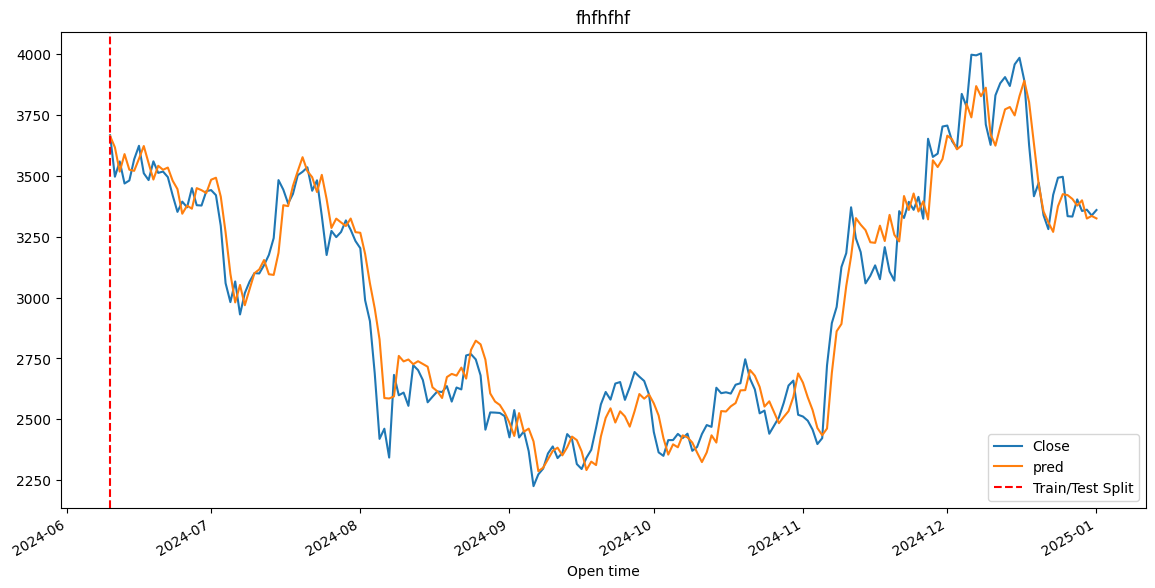

In [9]:
df["pred"] = np.nan
df.loc[df.index[-len(y_pred_inv):], "pred"] = y_pred_inv
df[["Close", "pred"]].iloc[-len(y_pred_inv):].plot(figsize=(14, 7), title="fhfhfhf")

plt.axvline(x=df.index[-len(y_pred_inv)], color='red', linestyle='--', label='Train/Test Split')
plt.legend()

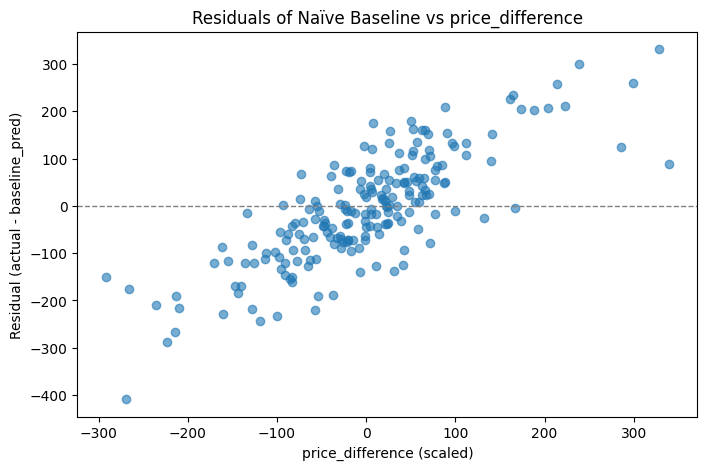

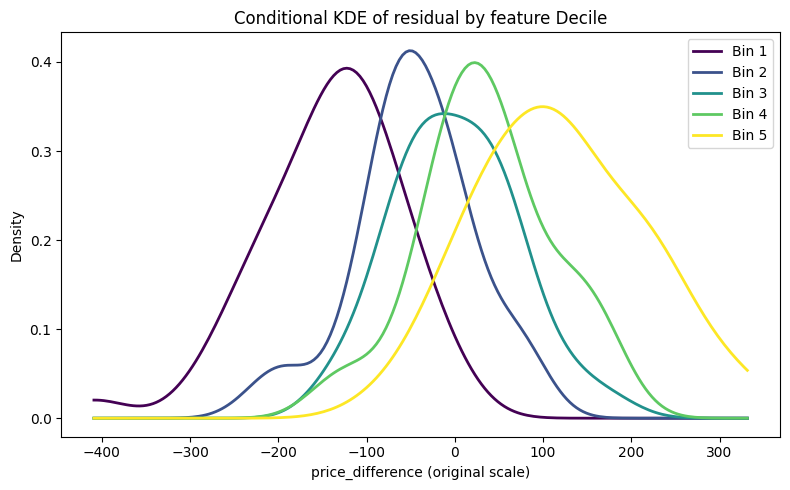

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats



# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_inv - y_pred_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_inv - pd.Series(y_val_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [11]:
# Save the trained model
best_model.save(SAVE_MODEL)

# Save the scaler
joblib.dump(best_scaler, SAVE_SCALER)

# Save the dataframe
best_df_all.to_csv(SAVE_DF)

# Save validation predictions with date index
val_predictions = pd.DataFrame({
    "Date": df.index[-len(best_y_val):],
    "Actual": y_val_inv,
    "Predicted": y_pred_inv
})
val_predictions.set_index("Date", inplace=True)
val_predictions.to_csv(SAVE_PREDICTIONS)